# Phân tích & Trực quan hóa Dữ liệu

Notebook này thực hiện các tác vụ phân tích và trực quan hóa:
1. Phân bố Rating
2. Top Items
3. Heatmap
4. Tần suất nhóm sản phẩm
5. Histogram bổ sung


In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Thiết lập hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Thiết lập font cho tiếng Việt (nếu cần)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Đã import các thư viện thành công!")


Đã import các thư viện thành công!


## 1. Load dữ liệu đã làm sạch


In [2]:
# Load dữ liệu đã làm sạch
try:
    books = pd.read_csv('../dataset/cleaned/Books_cleaned.csv')
    users = pd.read_csv('../dataset/cleaned/Users_cleaned.csv')
    ratings = pd.read_csv('../dataset/cleaned/Ratings_cleaned.csv')
    print("Đã load dữ liệu đã làm sạch thành công!")
except FileNotFoundError:
    # Nếu chưa có dữ liệu đã làm sạch, load dữ liệu gốc
    print("Chưa có dữ liệu đã làm sạch, đang load dữ liệu gốc...")
    books = pd.read_csv('../dataset/Books.csv')
    users = pd.read_csv('../dataset/Users.csv')
    ratings = pd.read_csv('../dataset/Ratings.csv')
    print("Đã load dữ liệu gốc!")

print(f"\nBooks shape: {books.shape}")
print(f"Users shape: {users.shape}")
print(f"Ratings shape: {ratings.shape}")


Đã load dữ liệu đã làm sạch thành công!

Books shape: (266730, 8)
Users shape: (277898, 3)
Ratings shape: (1149780, 3)


In [3]:
# Merge dữ liệu để có thông tin đầy đủ
# Merge ratings với books để có thông tin sách
ratings_with_books = ratings.merge(books[['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']], 
                                    on='ISBN', how='left')

# Merge ratings với users để có thông tin người dùng
ratings_with_users = ratings.merge(users[['User-ID', 'Age', 'Location']], 
                                   on='User-ID', how='left')

print("Đã merge dữ liệu thành công!")
print(f"Ratings with books shape: {ratings_with_books.shape}")
print(f"Ratings with users shape: {ratings_with_users.shape}")


Đã merge dữ liệu thành công!
Ratings with books shape: (1149780, 7)
Ratings with users shape: (1149780, 5)


## 2. Phân bố Rating


In [4]:
# Thống kê mô tả về Rating
print("=" * 50)
print("THỐNG KÊ PHÂN BỐ RATING")
print("=" * 50)
print(ratings['Book-Rating'].describe())
print(f"\nMode (giá trị xuất hiện nhiều nhất): {ratings['Book-Rating'].mode()[0]}")
print(f"Median: {ratings['Book-Rating'].median()}")
print(f"Mean: {ratings['Book-Rating'].mean():.2f}")

# Phân bố rating theo từng giá trị
rating_counts = ratings['Book-Rating'].value_counts().sort_index()
print("\n" + "=" * 50)
print("SỐ LƯỢNG RATING THEO TỪNG MỨC")
print("=" * 50)
print(rating_counts)


THỐNG KÊ PHÂN BỐ RATING
count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64

Mode (giá trị xuất hiện nhiều nhất): 0
Median: 0.0
Mean: 2.87

SỐ LƯỢNG RATING THEO TỪNG MỨC
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


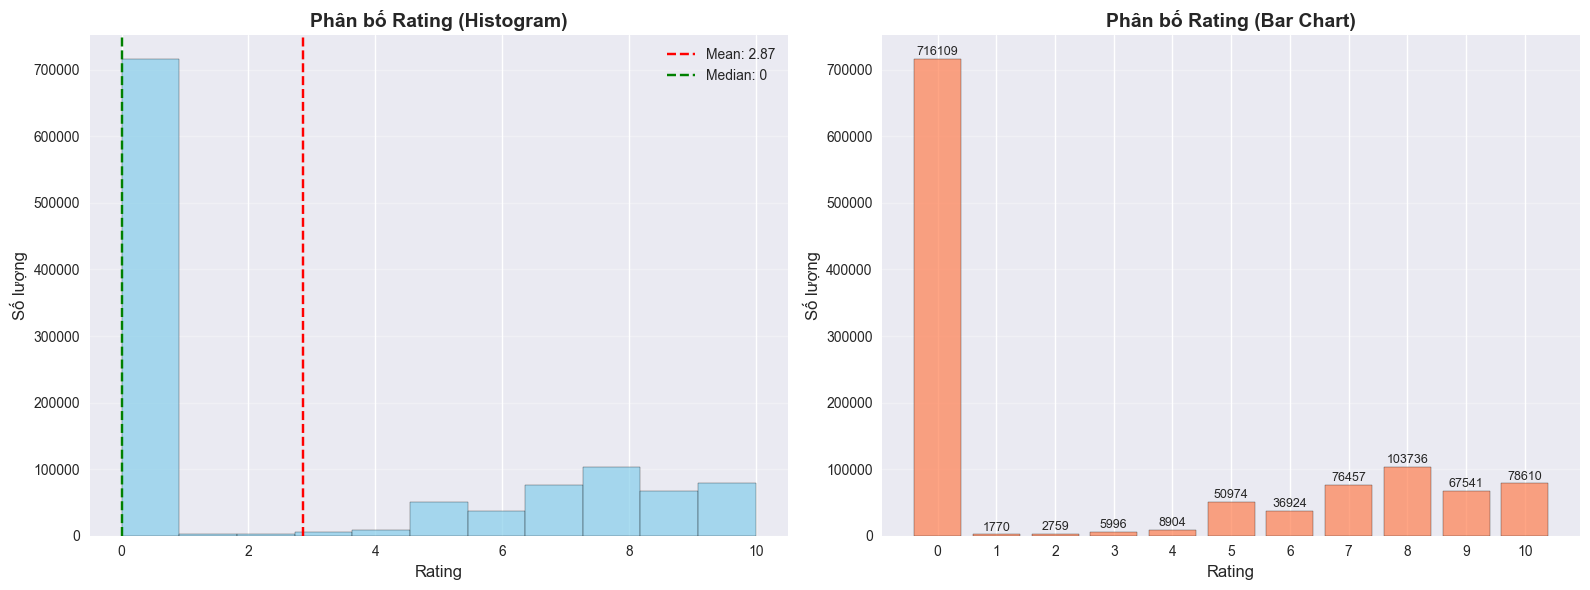

Tổng số rating: 1,149,780
Rating trung bình: 2.87
Rating phổ biến nhất: 0


In [5]:
# Histogram phân bố Rating
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(ratings['Book-Rating'], bins=11, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Phân bố Rating (Histogram)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Số lượng', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].axvline(ratings['Book-Rating'].mean(), color='red', linestyle='--', 
                label=f'Mean: {ratings["Book-Rating"].mean():.2f}')
axes[0].axvline(ratings['Book-Rating'].median(), color='green', linestyle='--', 
                label=f'Median: {ratings["Book-Rating"].median():.0f}')
axes[0].legend()

# Bar chart
rating_counts = ratings['Book-Rating'].value_counts().sort_index()
axes[1].bar(rating_counts.index, rating_counts.values, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title('Phân bố Rating (Bar Chart)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rating', fontsize=12)
axes[1].set_ylabel('Số lượng', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticks(range(0, 11))

# Thêm số liệu lên các cột
for i, v in enumerate(rating_counts.values):
    axes[1].text(rating_counts.index[i], v + 1000, str(v), 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Tổng số rating: {len(ratings):,}")
print(f"Rating trung bình: {ratings['Book-Rating'].mean():.2f}")
print(f"Rating phổ biến nhất: {ratings['Book-Rating'].mode()[0]}")


## 3. Top Items


In [6]:
# Top 10 sách được đánh giá nhiều nhất
top_books_by_count = ratings_with_books.groupby('ISBN').agg({
    'Book-Rating': ['count', 'mean'],
    'Book-Title': 'first',
    'Book-Author': 'first'
}).reset_index()

top_books_by_count.columns = ['ISBN', 'Rating_Count', 'Avg_Rating', 'Book-Title', 'Book-Author']
top_books_by_count = top_books_by_count.sort_values('Rating_Count', ascending=False).head(10)

print("=" * 70)
print("TOP 10 SÁCH ĐƯỢC ĐÁNH GIÁ NHIỀU NHẤT")
print("=" * 70)
print(top_books_by_count[['Book-Title', 'Book-Author', 'Rating_Count', 'Avg_Rating']].to_string(index=False))


TOP 10 SÁCH ĐƯỢC ĐÁNH GIÁ NHIỀU NHẤT
                                     Book-Title    Book-Author  Rating_Count  Avg_Rating
                                    Wild Animus   Rich Shapero          2502    1.019584
                      The Lovely Bones: A Novel   Alice Sebold          1295    4.468726
                              The Da Vinci Code      Dan Brown           883    4.652322
Divine Secrets of the Ya-Ya Sisterhood: A Novel  Rebecca Wells           732    3.448087
            The Red Tent (Bestselling Backlist)  Anita Diamant           723    4.334716
                                A Painted House   John Grisham           647    3.187017
                                           None           None           639    4.381847
                        The Secret Life of Bees  Sue Monk Kidd           615    4.219512
                         Snow Falling on Cedars David Guterson           614    3.255700
                            Angels &amp; Demons      Dan Brown           

In [7]:
# Top 10 sách có rating trung bình cao nhất (với ít nhất 50 đánh giá)
top_books_by_rating = ratings_with_books.groupby('ISBN').agg({
    'Book-Rating': ['count', 'mean'],
    'Book-Title': 'first',
    'Book-Author': 'first'
}).reset_index()

top_books_by_rating.columns = ['ISBN', 'Rating_Count', 'Avg_Rating', 'Book-Title', 'Book-Author']
# Lọc sách có ít nhất 50 đánh giá
top_books_by_rating = top_books_by_rating[top_books_by_rating['Rating_Count'] >= 50]
top_books_by_rating = top_books_by_rating.sort_values('Avg_Rating', ascending=False).head(10)

print("=" * 70)
print("TOP 10 SÁCH CÓ RATING TRUNG BÌNH CAO NHẤT (≥50 đánh giá)")
print("=" * 70)
print(top_books_by_rating[['Book-Title', 'Book-Author', 'Avg_Rating', 'Rating_Count']].to_string(index=False))


TOP 10 SÁCH CÓ RATING TRUNG BÌNH CAO NHẤT (≥50 đánh giá)
                                                Book-Title               Book-Author  Avg_Rating  Rating_Count
                                                      Free              Paul Vincent    7.962963            54
          Harry Potter and the Chamber of Secrets (Book 2)             J. K. Rowling    6.611765           170
              Harry Potter and the Goblet of Fire (Book 4)             J. K. Rowling    6.541237           194
         Harry Potter and the Prisoner of Azkaban (Book 3)             J. K. Rowling    6.467005           197
            Harry Potter and the Sorcerer's Stone (Book 1)             J. K. Rowling    6.363095           168
The Fellowship of the Ring (The Lord of the Rings, Part 1)          J. R. R. Tolkien    6.206349            63
                The Stand (The Complete and Uncut Edition)              Stephen King    6.175439            57
     Griffin &amp; Sabine: An Extraordinary Corresponde

TypeError: object of type 'NoneType' has no len()

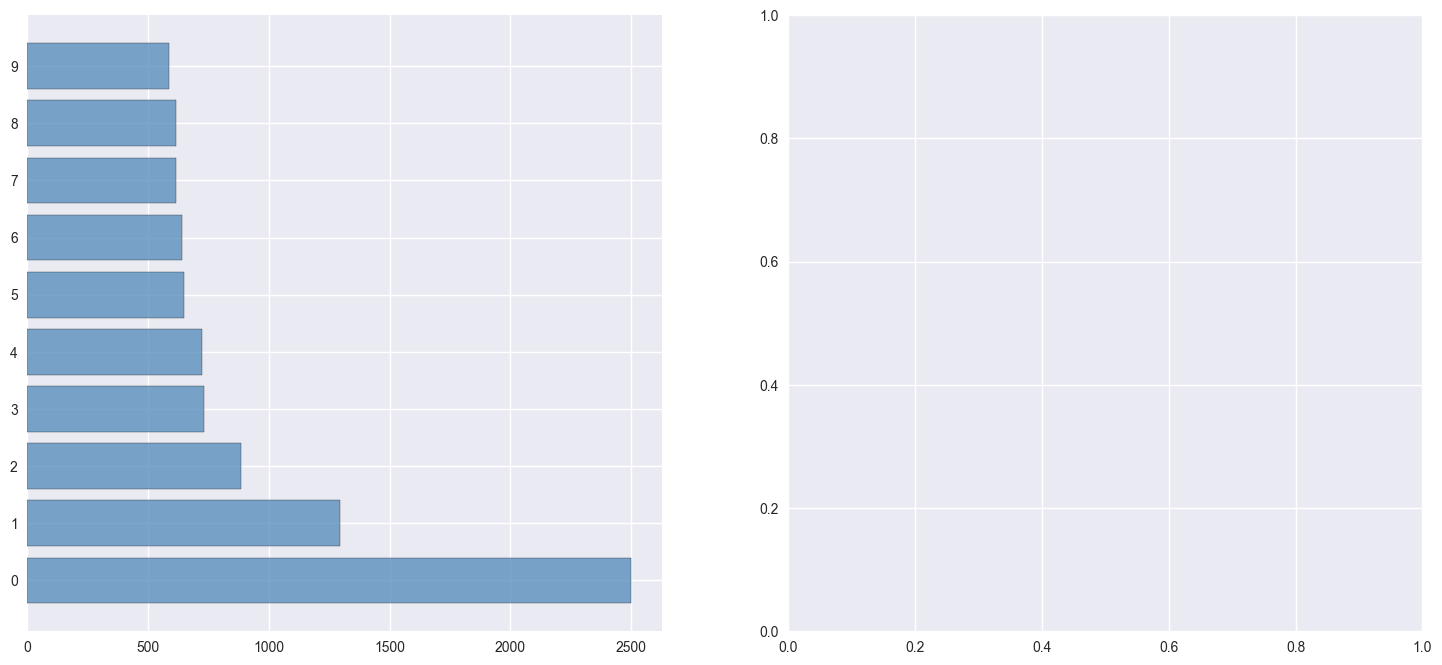

In [ ]:
# Visualize Top Books
# Helper function để xử lý None/NaN trong Book-Title
def format_title(title):
    if pd.isna(title) or title is None:
        return 'Unknown'
    title_str = str(title)
    return title_str[:40] + '...' if len(title_str) > 40 else title_str

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 10 sách được đánh giá nhiều nhất
top_10_count = top_books_by_count.head(10)
axes[0].barh(range(len(top_10_count)), top_10_count['Rating_Count'], 
             edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_yticks(range(len(top_10_count)))
axes[0].set_yticklabels([format_title(title) for title in top_10_count['Book-Title']], fontsize=9)
axes[0].set_xlabel('Số lượng đánh giá', fontsize=12)
axes[0].set_title('Top 10 Sách Được Đánh Giá Nhiều Nhất', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Thêm số liệu
for i, v in enumerate(top_10_count['Rating_Count']):
    axes[0].text(v + 50, i, str(v), va='center', fontsize=9)

# Top 10 sách có rating cao nhất
top_10_rating = top_books_by_rating.head(10)
axes[1].barh(range(len(top_10_rating)), top_10_rating['Avg_Rating'], 
             edgecolor='black', alpha=0.7, color='coral')
axes[1].set_yticks(range(len(top_10_rating)))
axes[1].set_yticklabels([format_title(title) for title in top_10_rating['Book-Title']], fontsize=9)
axes[1].set_xlabel('Rating trung bình', fontsize=12)
axes[1].set_title('Top 10 Sách Có Rating Cao Nhất (≥50 đánh giá)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()
axes[1].set_xlim([0, 10])

# Thêm số liệu
for i, v in enumerate(top_10_rating['Avg_Rating']):
    axes[1].text(v + 0.1, i, f'{v:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# Top 10 Tác giả được đánh giá nhiều nhất
top_authors = ratings_with_books.groupby('Book-Author').agg({
    'Book-Rating': ['count', 'mean'],
    'ISBN': 'nunique'  # Số lượng sách khác nhau
}).reset_index()

top_authors.columns = ['Author', 'Rating_Count', 'Avg_Rating', 'Book_Count']
top_authors = top_authors.sort_values('Rating_Count', ascending=False).head(10)

print("=" * 70)
print("TOP 10 TÁC GIẢ ĐƯỢC ĐÁNH GIÁ NHIỀU NHẤT")
print("=" * 70)
print(top_authors[['Author', 'Rating_Count', 'Book_Count', 'Avg_Rating']].to_string(index=False))


In [ ]:
# Top 10 Nhà xuất bản phổ biến nhất
top_publishers = ratings_with_books.groupby('Publisher').agg({
    'Book-Rating': 'count',
    'ISBN': 'nunique'  # Số lượng sách khác nhau
}).reset_index()

top_publishers.columns = ['Publisher', 'Rating_Count', 'Book_Count']
top_publishers = top_publishers.sort_values('Rating_Count', ascending=False).head(10)

print("=" * 70)
print("TOP 10 NHÀ XUẤT BẢN PHỔ BIẾN NHẤT")
print("=" * 70)
print(top_publishers[['Publisher', 'Rating_Count', 'Book_Count']].to_string(index=False))


In [ ]:
# Visualize Top Authors và Top Publishers
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 10 Authors
top_10_authors = top_authors.head(10)
axes[0].barh(range(len(top_10_authors)), top_10_authors['Rating_Count'], 
             edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0].set_yticks(range(len(top_10_authors)))
axes[0].set_yticklabels([author[:30] + '...' if len(author) > 30 else author 
                         for author in top_10_authors['Author']], fontsize=9)
axes[0].set_xlabel('Số lượng đánh giá', fontsize=12)
axes[0].set_title('Top 10 Tác Giả Được Đánh Giá Nhiều Nhất', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Thêm số liệu
for i, v in enumerate(top_10_authors['Rating_Count']):
    axes[0].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

# Top 10 Publishers
top_10_publishers = top_publishers.head(10)
axes[1].barh(range(len(top_10_publishers)), top_10_publishers['Rating_Count'], 
             edgecolor='black', alpha=0.7, color='gold')
axes[1].set_yticks(range(len(top_10_publishers)))
axes[1].set_yticklabels([pub[:30] + '...' if len(pub) > 30 else pub 
                         for pub in top_10_publishers['Publisher']], fontsize=9)
axes[1].set_xlabel('Số lượng đánh giá', fontsize=12)
axes[1].set_title('Top 10 Nhà Xuất Bản Phổ Biến Nhất', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# Thêm số liệu
for i, v in enumerate(top_10_publishers['Rating_Count']):
    axes[1].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


## 4. Heatmap


In [ ]:
# Tạo User-Item Rating Matrix (sample)
# Lấy sample 50 users và 50 items để visualize
np.random.seed(42)

# Lấy top 50 users có nhiều rating nhất
top_users = ratings['User-ID'].value_counts().head(50).index.tolist()
# Lấy top 50 books có nhiều rating nhất
top_books_isbn = ratings['ISBN'].value_counts().head(50).index.tolist()

# Filter ratings
sample_ratings = ratings[
    (ratings['User-ID'].isin(top_users)) & 
    (ratings['ISBN'].isin(top_books_isbn))
]

# Tạo pivot table
rating_matrix = sample_ratings.pivot_table(
    index='User-ID', 
    columns='ISBN', 
    values='Book-Rating', 
    fill_value=0
)

print(f"Rating Matrix shape: {rating_matrix.shape}")
print(f"Số lượng ratings trong matrix: {(rating_matrix > 0).sum().sum()}")
print(f"Tỷ lệ sparse: {(1 - (rating_matrix > 0).sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1])) * 100:.2f}%")


In [ ]:
# Heatmap User-Item Rating Matrix
plt.figure(figsize=(16, 12))
sns.heatmap(rating_matrix, 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Rating'},
            vmin=0, 
            vmax=10,
            square=False,
            linewidths=0.1,
            linecolor='gray',
            xticklabels=False,
            yticklabels=False)
plt.title('Heatmap: User-Item Rating Matrix (Sample 50x50)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Books (ISBN)', fontsize=12)
plt.ylabel('Users (User-ID)', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Heatmap: Phân bố Rating theo Năm xuất bản
# Tạo bảng cross-tab giữa Year và Rating
ratings_with_year = ratings_with_books[ratings_with_books['Year-Of-Publication'].notna()].copy()
ratings_with_year['Year-Of-Publication'] = ratings_with_year['Year-Of-Publication'].astype(int)

# Chọn các năm có nhiều rating nhất
top_years = ratings_with_year['Year-Of-Publication'].value_counts().head(20).index.tolist()
ratings_year_filtered = ratings_with_year[ratings_with_year['Year-Of-Publication'].isin(top_years)]

# Tạo cross-tab
year_rating_crosstab = pd.crosstab(
    ratings_year_filtered['Year-Of-Publication'], 
    ratings_year_filtered['Book-Rating']
)

# Sắp xếp theo năm
year_rating_crosstab = year_rating_crosstab.sort_index()

plt.figure(figsize=(14, 8))
sns.heatmap(year_rating_crosstab, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'label': 'Số lượng'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Heatmap: Phân bố Rating theo Năm Xuất Bản', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Năm Xuất Bản', fontsize=12)
plt.tight_layout()
plt.show()


## 5. Tần suất nhóm sản phẩm


In [ ]:
# Tần suất sách theo Publisher (Top 15)
publisher_counts = books['Publisher'].value_counts().head(15)

print("=" * 70)
print("TOP 15 NHÀ XUẤT BẢN THEO SỐ LƯỢNG SÁCH")
print("=" * 70)
print(publisher_counts)


In [ ]:
# Tần suất sách theo Author (Top 15)
author_counts = books['Book-Author'].value_counts().head(15)

print("=" * 70)
print("TOP 15 TÁC GIẢ THEO SỐ LƯỢNG SÁCH")
print("=" * 70)
print(author_counts)


In [ ]:
# Visualize Tần suất nhóm sản phẩm
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top Publishers
top_15_publishers = publisher_counts.head(15)
axes[0].barh(range(len(top_15_publishers)), top_15_publishers.values, 
             edgecolor='black', alpha=0.7, color='teal')
axes[0].set_yticks(range(len(top_15_publishers)))
axes[0].set_yticklabels([pub[:40] + '...' if len(pub) > 40 else pub 
                         for pub in top_15_publishers.index], fontsize=10)
axes[0].set_xlabel('Số lượng sách', fontsize=12)
axes[0].set_title('Top 15 Nhà Xuất Bản Theo Số Lượng Sách', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Thêm số liệu
for i, v in enumerate(top_15_publishers.values):
    axes[0].text(v + 10, i, str(v), va='center', fontsize=9)

# Top Authors
top_15_authors = author_counts.head(15)
axes[1].barh(range(len(top_15_authors)), top_15_authors.values, 
             edgecolor='black', alpha=0.7, color='salmon')
axes[1].set_yticks(range(len(top_15_authors)))
axes[1].set_yticklabels([author[:40] + '...' if len(author) > 40 else author 
                         for author in top_15_authors.index], fontsize=10)
axes[1].set_xlabel('Số lượng sách', fontsize=12)
axes[1].set_title('Top 15 Tác Giả Theo Số Lượng Sách', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# Thêm số liệu
for i, v in enumerate(top_15_authors.values):
    axes[1].text(v + 1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# Phân bố sách theo Năm xuất bản
# Chuyển đổi Year-Of-Publication sang số nếu chưa
if books['Year-Of-Publication'].dtype == 'object':
    books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

books_year_valid = books[books['Year-Of-Publication'].notna() & 
                         (books['Year-Of-Publication'] >= 1900) & 
                         (books['Year-Of-Publication'] <= 2024)]

year_counts = books_year_valid['Year-Of-Publication'].value_counts().sort_index()

print("=" * 70)
print("PHÂN BỐ SÁCH THEO NĂM XUẤT BẢN (1900-2024)")
print("=" * 70)
print(f"Tổng số năm: {len(year_counts)}")
print(f"Năm xuất bản nhiều sách nhất: {year_counts.idxmax()} ({year_counts.max()} sách)")
print(f"Năm xuất bản ít sách nhất: {year_counts.idxmin()} ({year_counts.min()} sách)")


In [ ]:
# Visualize Phân bố sách theo Năm
plt.figure(figsize=(16, 6))
plt.bar(year_counts.index, year_counts.values, edgecolor='black', alpha=0.7, color='purple')
plt.title('Phân Bố Sách Theo Năm Xuất Bản', fontsize=16, fontweight='bold')
plt.xlabel('Năm Xuất Bản', fontsize=12)
plt.ylabel('Số lượng sách', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Histogram bổ sung


In [ ]:
# Phân bố Age của Users
users_age_valid = users[users['Age'].notna() & 
                         (users['Age'] >= 5) & 
                         (users['Age'] <= 120)]

print("=" * 50)
print("PHÂN BỐ AGE CỦA USERS")
print("=" * 50)
print(users_age_valid['Age'].describe())


In [ ]:
# Phân bố số lượng Rating per User
ratings_per_user = ratings.groupby('User-ID')['Book-Rating'].count()

print("=" * 50)
print("PHÂN BỐ SỐ LƯỢNG RATING PER USER")
print("=" * 50)
print(ratings_per_user.describe())
print(f"\nUser có nhiều rating nhất: {ratings_per_user.max()} ratings")
print(f"User có ít rating nhất: {ratings_per_user.min()} ratings")


In [ ]:
# Visualize các Histogram bổ sung
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Phân bố Age
axes[0, 0].hist(users_age_valid['Age'], bins=50, edgecolor='black', alpha=0.7, color='lightblue')
axes[0, 0].set_title('Phân Bố Age của Users', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Age', fontsize=12)
axes[0, 0].set_ylabel('Số lượng', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axvline(users_age_valid['Age'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {users_age_valid["Age"].mean():.1f}')
axes[0, 0].legend()

# 2. Phân bố Year-Of-Publication
axes[0, 1].hist(books_year_valid['Year-Of-Publication'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Phân Bố Năm Xuất Bản của Sách', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Năm', fontsize=12)
axes[0, 1].set_ylabel('Số lượng', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Phân bố Ratings per User (log scale để dễ nhìn)
axes[1, 0].hist(ratings_per_user, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 0].set_title('Phân Bố Số Lượng Rating Per User', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Số lượng rating', fontsize=12)
axes[1, 0].set_ylabel('Số lượng users', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Phân bố Ratings per User (log scale)
axes[1, 1].hist(ratings_per_user, bins=50, edgecolor='black', alpha=0.7, color='plum')
axes[1, 1].set_title('Phân Bố Số Lượng Rating Per User (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Số lượng rating (log)', fontsize=12)
axes[1, 1].set_ylabel('Số lượng users (log)', fontsize=12)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Tổng kết và Insights


In [ ]:
# Tổng kết các insights chính
print("=" * 70)
print("TỔNG KẾT PHÂN TÍCH DỮ LIỆU")
print("=" * 70)

print("\n1. PHÂN BỐ RATING:")
print(f"   - Rating trung bình: {ratings['Book-Rating'].mean():.2f}/10")
print(f"   - Rating phổ biến nhất: {ratings['Book-Rating'].mode()[0]}/10")
print(f"   - Tổng số rating: {len(ratings):,}")

print("\n2. TOP ITEMS:")
print(f"   - Sách được đánh giá nhiều nhất: {top_books_by_count.iloc[0]['Book-Title'][:50]}...")
print(f"   - Tác giả được đánh giá nhiều nhất: {top_authors.iloc[0]['Author']}")
print(f"   - Nhà xuất bản phổ biến nhất: {top_publishers.iloc[0]['Publisher']}")

print("\n3. PHÂN BỐ DỮ LIỆU:")
print(f"   - Tổng số sách: {len(books):,}")
print(f"   - Tổng số users: {len(users):,}")
print(f"   - Tuổi trung bình của users: {users_age_valid['Age'].mean():.1f}")
print(f"   - Năm xuất bản nhiều sách nhất: {year_counts.idxmax()}")

print("\n4. SPARSITY:")
print(f"   - Tỷ lệ sparse trong rating matrix (sample): {(1 - (rating_matrix > 0).sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1])) * 100:.2f}%")
print(f"   - Số rating trung bình per user: {ratings_per_user.mean():.2f}")

print("\n" + "=" * 70)
print("HOÀN THÀNH PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU!")
print("=" * 70)
